Chase P. Dowling

November 2021

Pacific Northwest National Laboratory

chase.dowling@pnnl.gov

## An Empirical Taxonomy of Common Curb Zoning Configurations in Seattle

This notebook contains relevant data and methods to reproduce results found in Dowling, Maxer, and Ranjbari (2022) "An Empirical Taxonomy of Common Curb Zoning Configurations in Seattle", computing an empirically representative set of curb configurations in Seattle, Washington, USA, using an unsupervised clustering methodology and high spatial resolution curb configuration data.

In [22]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#conda environment name curb_cluster
#run conda activate curb_cluster

import random
import json
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
from kmodes.kmodes import KModes #Devos (2015) https://github.com/nicodv/kmodes
from kmodes.util import dissim

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

import seaborn
seaborn.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data Preprocessing

Here we load the data on curb zoning in Seattle for 2019. Data is available for download and described [here](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::paid-area-curbspaces/about).
This data is used to populate a map of curb space use in Seattle, for reference purposes, closures, etc, viewable in map form [here](https://seattlecitygis.maps.arcgis.com/apps/MapSeries/index.html?appid=ec2bf6796118412982072feb28d35277). Please note the relevant length data is published in Imperial units of feet.

In [3]:
data = pd.read_csv("Curbspaces_2019.csv")

In [4]:
space_types = list(data.SPACETYPEDESC.unique()) #get all space types
space_types.append("MISSING") #turns out there are segments where the label is missing so we add a placeholder

print("Curb zoning types used in Seattle:")
for item in space_types: print("\t" + item)

Curb zoning types used in Seattle:
	CROSSWALK
	PAY STATION
	CLEARANCE
	DRIVEWAY
	NO PARKING
	PAY STATION - TEMP REMOVAL
	TOW AWAY ZONE
	CURB BULB
	CURB RAMP
	HYDRANT
	SHUTTLE BUS ONLY
	LOAD/UNLOAD ZONE
	TIME LIMIT - RES PARKING ZONE
	UNRESTRICTED
	BARRIER AREA
	NOT A DESIGNATED CROSSWALK
	COMMERCIAL VEHICLE LOAD ZONE
	PASSENGER LOAD ZONE
	TIME LIMIT
	PAY STATION - TAXI
	BUS ZONE
	PAY STATION - CVLZ
	PAY STATION - BUS LAYOVER
	ALLEY
	DISABLED ZONE
	PAY STATION - LOAD/UNLOAD ZONE
	CVLZ - PLZ
	PAY STATION - PLZ
	BIKE ZONE
	PAY STATION - MOTORCYCLE
	PAY STATION - VENDOR
	PAY STATION - BUS ZONE
	PAY STATION - SHUTTLE BUS ONLY
	LAW ENFORCEMENT VEHICLES ONLY
	SEATTLE FIRE DEPT ZONE
	TIME LIMIT - PLZ
	PAY STATION - LEVO
	PARKLET
	CHARTER BUS ZONE
	TIME LIMIT - LOAD/UNLOAD ZONE
	CARSHARE/FLEXCAR
	OTHER SPACE TYPE - YES PARKING
	PAY STATION - SCHOOL
	TRUCK LOAD/UNLOAD ZONE
	BUS LAYOVER ZONE
	CVLZ - TRUCK LOAD ONLY
	TAXI ZONE
	PAY STATION - DISABLED
	OTHER SPACE TYPE - NO PARKING
	CVLZ - BUS ZONE

In [5]:
#map all unique space types to an integer for reference
j = 0
integer_mapping = {}
for space_type in space_types:
    integer_mapping[space_type] = j
    j += 1

#ad hoc mapping of space types to a color for later plotting
max_j = np.max(list(integer_mapping.values()))
space_integer_color_map = {}
colors_ordered = list(mcolors.CSS4_COLORS.keys())
random.shuffle(colors_ordered)

for i in range(max_j+1):
    space_integer_color_map[i] = colors_ordered[i]
space_integer_color_map[max_j] = 'black' #manually map the "MISSING" label to black

In [8]:
#Here we condense zone types to categories of related use. This is highly specific to the labels available in Seattle

condensed_space_types_map = {}
for item in ["CLEARANCE", "CURB BULB", "CURB RAMP", "BARRIER AREA", "PARKLET"]:
    condensed_space_types_map[item] = "CURB_FEATURE"
for item in ["DRIVEWAY", "ALLEY"]:
    condensed_space_types_map[item] = "DRIVEWAY"
for item in ["PAY STATION", "PAY STATION - TEMP REMOVAL", "PAY STATION - LOAD/UNLOAD ZONE", "PAY STATION - TAXI", "PAY STATION - CVLZ", "PAY STATION - BUS LAYOVER", "PAY STATION - PLZ", "PAY STATION - MOTORCYCLE", 
          "PAY STATION - VENDOR", "PAY STATION - BUS ZONE", "PAY STATION - SHUTTLE BUS ONLY", "PAY STATION - LEVO", "PAY STATION - SCHOOL", "PAY STATION - CARPOOL", "PAY STATION - TRUCK L/U ZONE", "PAY STATION - RES PARKING ZONE"]:
    condensed_space_types_map[item] = "PAID"
for item in ["NO PARKING", "TOW AWAY ZONE", "OTHER SPACE TYPE - NO PARKING", "NOT A DESIGNATED CROSSWALK"]:
    condensed_space_types_map[item] = "NO_PARKING"
for item in ["PAY STATION - DISABLED", "DISABLED ZONE"]:
    condensed_space_types_map[item] = "DISABLED"
for item in ["LOAD/UNLOAD ZONE", "COMMERCIAL VEHICLE LOAD ZONE", "CVLZ - PLZ", "CVLZ - TRUCK LOAD ONLY", "CVLZ - BUS ZONE", "CVLZ - SIGN ONLY", "TRUCK LOAD/UNLOAD ZONE"]:
    condensed_space_types_map[item] = "CVLZ"
for item in ["PASSENGER LOAD ZONE", "PASSENGER LOAD ZONE - VENDING ZONE", "TAXI ZONE", "CARSHARE/FLEXCAR"]:
    condensed_space_types_map[item] = "PLZ"
for item in ["SHUTTLE BUS ONLY", "BUS ZONE", "CHARTER BUS ZONE", "BUS LAYOVER ZONE"]:
    condensed_space_types_map[item] = "BUS"
for item in ["HYDRANT", "LAW ENFORCEMENT VEHICLES ONLY", "SEATTLE FIRE DEPT ZONE"]:
    condensed_space_types_map[item] = "EMERGENCY"
for item in ["TIME LIMIT - RES PARKING ZONE", "TIME LIMIT", "TIME LIMIT - PLZ", "TIME LIMIT - LOAD/UNLOAD ZONE", "TIME LIMIT - BUS LAYOVER", "TIME LIMIT - PEAK PM", "TIME LIMIT - TRUCK L/U ZONE"]:
    condensed_space_types_map[item] = "DYNAMIC/FREE"
for item in ["UNRESTRICTED", "OTHER SPACE TYPE - YES PARKING"]:
    condensed_space_types_map[item] = "UNRESTRICTED"

#map condensed types to integers
j = 0
condensed_integer_mapping = {}
for space_type in space_types:
    if space_type in condensed_space_types_map.keys():
        space_type_condensed = condensed_space_types_map[space_type]
    else:
        space_type_condensed = space_type
    if space_type_condensed not in condensed_integer_mapping.keys():
        condensed_integer_mapping[space_type_condensed] = j
        j += 1
    else:
        pass

print("These are the condensed curb zoning types")
for item in condensed_integer_mapping.keys():
    print("\t" + item)
    
#map each zoning type to a color for later plotting
max_j = np.max(list(condensed_integer_mapping.values()))
condensed_space_integer_color_map = {}
colors_ordered = list(mcolors.CSS4_COLORS.keys())
random.shuffle(colors_ordered)

for i in range(max_j+1):
    condensed_space_integer_color_map[i] = colors_ordered[i]
condensed_space_integer_color_map[max_j] = 'black'

These are the condensed curb zoning types
	CROSSWALK
	PAID
	CURB_FEATURE
	DRIVEWAY
	NO_PARKING
	EMERGENCY
	BUS
	CVLZ
	DYNAMIC/FREE
	UNRESTRICTED
	PLZ
	DISABLED
	BIKE ZONE
	CONSULATE ZONE
	CARPOOL PARKING - FULL TIME
	MISSING


In [9]:
#check all blockface sortings by BLOCK_ST and 
#BLOCK_END if there are multiple dates accounted for in data

#If distance measurements for a zoning are repeated or misaligned we toss that blockface for the purpose of this analysis

#get all elementkeys (unique integer ID's of all blockfaces in Seattle)
ekeys = data.ELMNTKEY.unique()

bad_keys = set()
for ekey in ekeys:
    block_data = data.loc[ data['ELMNTKEY'] == ekey ]
    
    block_st = block_data.BLOCK_ST.values
    block_st_set = list(block_data.BLOCK_ST.unique())
    diff = len(block_st) - len(block_st_set)
    if diff != 0:
        bad_keys.add(ekey)
    
    block_end = block_data.BLOCK_END.values
    block_end_set = list(block_data.BLOCK_END.unique())
    diff = len(block_end) - len(block_end_set)
    if diff != 0:
        bad_keys.add(ekey)
bad_keys = list(bad_keys)

print("Misaligned blockfaces that are being tossed out")
print(bad_keys)
print(np.around((len(bad_keys)/len(ekeys))*100, 2), "% of", len(ekeys), "blockfaces total")

Misaligned blockfaces that are being tossed out
[31490, 9465, 77318, 57861, 78853, 36105, 54541, 32910, 36493, 57901, 37433, 32469, 1589, 56085, 57269, 77369, 56318, 36126]
0.67 % of 2697 blockfaces total


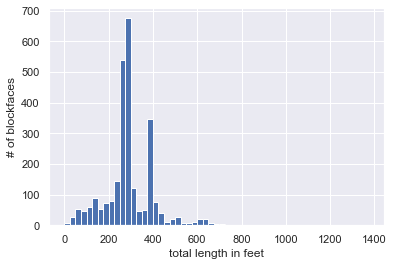

In [10]:
#Blockface lengths and constituent zones are measured to within a tenth of a foot
#Here we bin blockfaces by length, increments of 25 feet, for the purpose of clustering blockfaces of similar length
lengths = []
length_bins = [ [] for i in range(int(2000/25)) ]

for ekey in ekeys:
    if ekey in bad_keys:
        pass
    else:
        block_data = data.loc[data['ELMNTKEY'] == ekey]
        block_length = block_data.SHAPE_Length.sum()
        lengths.append(block_length)
        length_bin_i = int(block_length/25)
        length_bins[length_bin_i].append(ekey)
        
plt.hist(lengths, bins=np.arange(0,1400,25))
plt.xlabel("total length in feet")
plt.ylabel("# of blockfaces")
plt.show()

#For reference, the largest bins are:
#676 blockfaces in [275,300) ekeys in index 11 of length_bins
#539 blockfaces in [250,275) index 10
#348 blockfaces in [375,400) index 15

In [46]:
#here we compute all the length normalized blockface label sequences for every blockface elementkey, and each subsequent experiment draws on this list for various subsets of elementkeys (e.g. downtown core only, similar block lengths only)

block_allocs_norm_length = {} #will map blockface ekey to length normalized zoning of blockface
block_allocs_norm_length_condensed = {} #will map blockface ekey to length normalized condensed zoning of blockface

label_increment = 0.4 #for generating blockface label vectors that depend on the length of the blockface #0.49 is minimum positive difference between labels
normed_vector_length = 100 #for generating blockface label vectors of all equal total length
max_block_len = 0

#for element key, get all rows
for ekey in ekeys:
    if ekey in bad_keys:
        pass
    else:
        block_data = data.loc[data['ELMNTKEY'] == ekey]

        #need to sort sequence of BLOCK_ST to BLOCK_END
        block_data = block_data.sort_values('BLOCK_ST')
        block_st = np.min(block_data.BLOCK_ST.values) #numercial start of all zonings on block
        block_end = np.max(block_data.BLOCK_END.values) #numercial end of all zonings on block
        total_len = block_end - block_st

        #populate vector of normalized length with labels
        length_normal_label_vector = [ "" for i in range(normed_vector_length) ] #label vector thats normalized to the same length for all blockfaces
        condensed_length_normal_label_vector = [ "" for i in range(normed_vector_length) ]

        #iterate through zonings for current blockface
        for index, row in block_data.iterrows():
            curr_zone = integer_mapping[row['SPACETYPEDESC']] #get integer label
            try:
                condensed_curr_zone = condensed_integer_mapping[condensed_space_types_map[row['SPACETYPEDESC']]] #get condensed integer label
            except:
                condensed_curr_zone = condensed_integer_mapping[row['SPACETYPEDESC']]
            b_seg_st = row['BLOCK_ST'] #get the numercial start of current zoning
            b_seg_end = row['BLOCK_END'] #get the numerical end of current zoning

            #normalize and get normed_length_vector_length dependent indecies
            norm_seg_st = (b_seg_st - block_st)/(total_len) #get 0-1 position of current zoning start on current block
            norm_seg_end = (b_seg_end - block_st)/(total_len) #get 0-1 position of current zoning end on current block
            st_ind = int(norm_seg_st*normed_vector_length) #recall int() is natively a floor function, so no overlaps
            end_ind = int(norm_seg_end*normed_vector_length)
            for i in range(st_ind, end_ind+1):
                if i == normed_vector_length:
                    pass
                else:
                    length_normal_label_vector[i] = curr_zone
                    condensed_length_normal_label_vector[i] = condensed_curr_zone

        #update block zonings            
        for j, item in enumerate(length_normal_label_vector):
            if item == "":
                length_normal_label_vector[j] = integer_mapping["MISSING"]
                condensed_length_normal_label_vector[j] = condensed_integer_mapping["MISSING"]
        block_allocs_norm_length[ekey] = length_normal_label_vector
        block_allocs_norm_length_condensed[ekey] = condensed_length_normal_label_vector

In [47]:
#print an example input sample

example_block = block_allocs_norm_length[ekeys[0]]
labeled_vector = [ space_types[i] for i in example_block ]
print(labeled_vector)
print("\n")

#recall, this vector represents an order-preserving sequence of curb zones. Each element is 0.1% of the total curb length. The first 15 labels are "CLEARANCE", meaning that 1.5% of the total blockface length at one
#end of the curb is dedicated to "CLEARANCE" zoning. This is approximately 4 feet

block_data = data.loc[data['ELMNTKEY'] == ekeys[0]]
block_length = block_data.SHAPE_Length.sum()
print(0.015*block_length, " feet")

['CLEARANCE', 'CROSSWALK', 'CROSSWALK', 'CROSSWALK', 'CROSSWALK', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'PASSENGER LOAD ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'TOW AWAY ZONE', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING', 'NO PARKING',

## Analysis

### Clustering all blockfaces regardless of location and true length

In [ ]:
# setting this ensures reported results can be reproduced exactly, comment out this line for new analyses
np.random.seed(123123)

In [66]:
#Using basic matching dissimliarty in kmodes.dissim takes some time to compute on a laptop

#cluster normalized length vectors
#stack samples into train and validation data sets
all_data = []
for ekey in block_allocs_norm_length.keys():
    all_data.append(block_allocs_norm_length[ekey])
all_data = np.asarray(all_data)
print(all_data.shape[0], " total samples")

val_inds = np.random.choice(all_data.shape[0], size=int(0.1*all_data.shape[0]), replace=False) #hold out 10% of the data for cross validation
train_inds = np.asarray([i for i in range(all_data.shape[0]) if i not in val_inds]) #use the rest for training

train_data = all_data[train_inds,:]
val_data = all_data[val_inds,:]

models = []
counter = 0
k_max = 35 #here we look at clustering results for k = 2 through k_max to decide on an optimal number k via held-out cross validation

for i in range(2,k_max):
    print("Training model for ", str(i), "clusters")
    
    #initialize and train the model
    km = KModes(n_clusters=i, init='Cao', n_init=5, verbose=0)
    clusters = km.fit_predict(train_data)
    models.append([km])
    
    #get the predicted clusters of the held out training and validation data
    val_assignments = np.asarray(km.predict(val_data))
    train_assignments = np.asarray(km.predict(train_data))
    
    val_var_dists = []
    train_var_dists = []
    for j in range(i):
        #inds = np.where(np.any(assignments==0, axis=0))
        val_inds = np.argwhere(val_assignments==j)[:,0]
        train_inds = np.argwhere(train_assignments==j)[:,0]

        #compute within cluster variance with dissim.matching_dissim for training and validation data, when validation data distance variance diverges as a function k, we know k is too large and the model has overfit
        centroid = km.cluster_centroids_[j]
        train_dist = dissim.matching_dissim(train_data[inds,:], centroid) #compute the distances of all the training samples
        train_var_dist = np.var(train_dist) #compute the variance of these distances
        train_var_dists.append(train_var_dist) #save with model
        
        val_dist = dissim.matching_dissim(val_data[inds,:], centroid) #compute the distances of all the validation samples
        val_var_dist = np.var(val_dist) #compute the variance of these distances
        val_var_dists.append(val_var_dist) #save with model
        
    models[counter].append(np.mean(train_var_dists))
    models[counter].append(np.mean(val_var_dists))
    
    counter+=1 #increment counter for saving models and validation score
    km = None #reset model variable

2679  total samples
Training model for  2 clusters
Training model for  3 clusters
Training model for  4 clusters
Training model for  5 clusters
Training model for  6 clusters
Training model for  7 clusters
Training model for  8 clusters
Training model for  9 clusters
Training model for  10 clusters
Training model for  11 clusters
Training model for  12 clusters
Training model for  13 clusters
Training model for  14 clusters
Training model for  15 clusters
Training model for  16 clusters
Training model for  17 clusters
Training model for  18 clusters
Training model for  19 clusters
Training model for  20 clusters
Training model for  21 clusters
Training model for  22 clusters
Training model for  23 clusters
Training model for  24 clusters
Training model for  25 clusters
Training model for  26 clusters
Training model for  27 clusters
Training model for  28 clusters
Training model for  29 clusters
Training model for  30 clusters
Training model for  31 clusters
Training model for  32 clust

In [73]:
#save models, load models, for later analysis
#Here we're saving results from k's 2 to 34, for zoning increments of 1%

for i in range(k_max-2):
    if not os.path.exists("models/n_" + str(normed_vector_length) + "_all_blockfaces"):
        os.mkdir("models/n_" + str(normed_vector_length) + "_all_blockfaces")
    with open("models/n_" + str(normed_vector_length) + "_all_blockfaces/k_" + str(i) + "_n_" + str(normed_vector_length) + ".pck", 'wb') as d:
        pickle.dump(models[i], d)

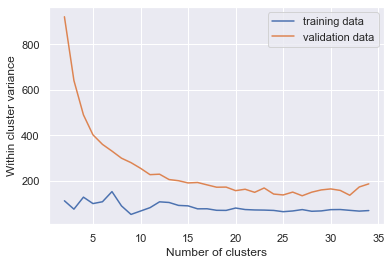

In [67]:
#plot validation within-cluster variance
train_variances = [i[1] for i in models ]
val_variances = [ i[2] for i in models ]

plt.plot(np.arange(2,k_max,1), train_variances, label="training data")
plt.plot(np.arange(2,k_max,1), val_variances, label="validation data")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster variance")
plt.legend()
plt.show()

In [ ]:
#To do: Assume block-faces are Poisson distributed across clusters, compute exponential fit (smaller parameter = fatter tail). This will tell us if we're identifying latent clusters as k increases

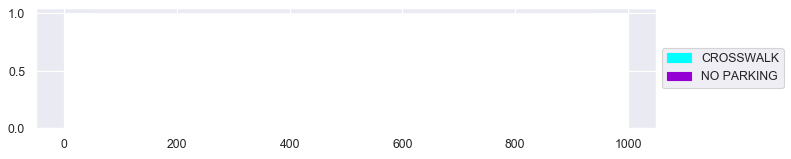

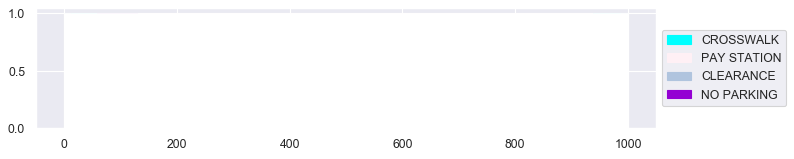

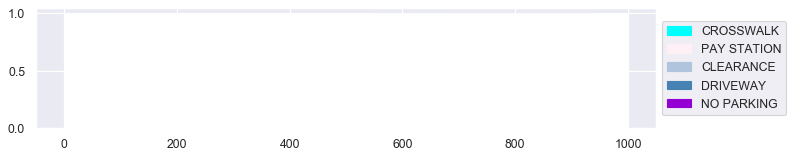

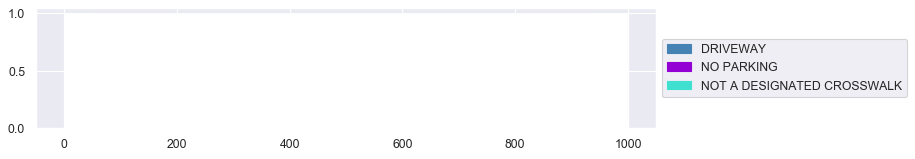

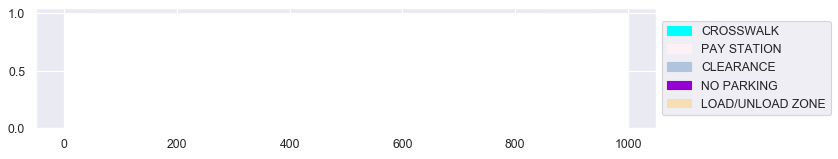

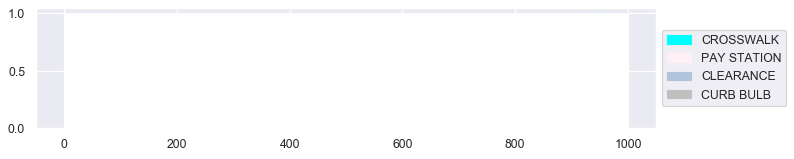

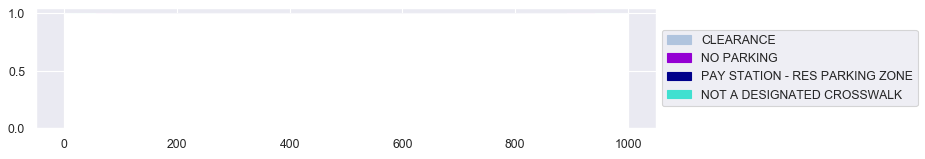

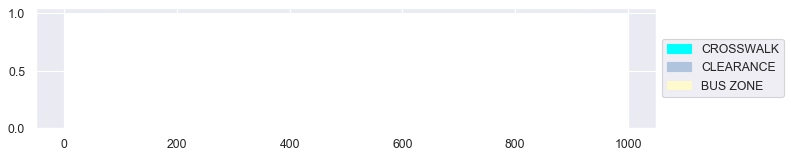

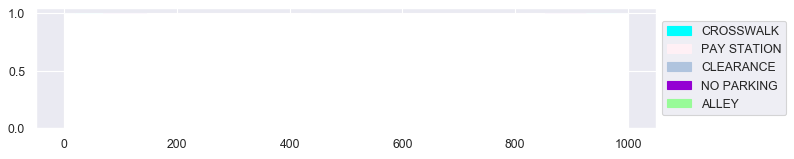

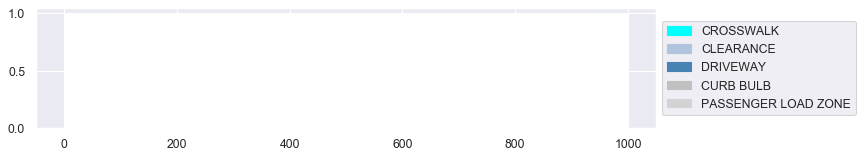

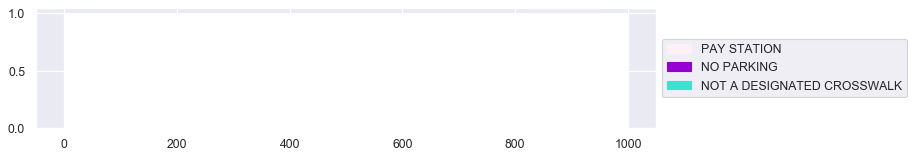

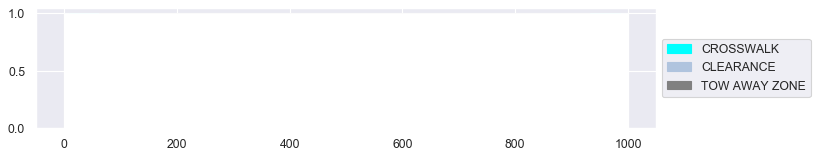

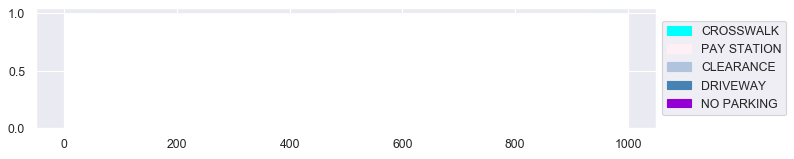

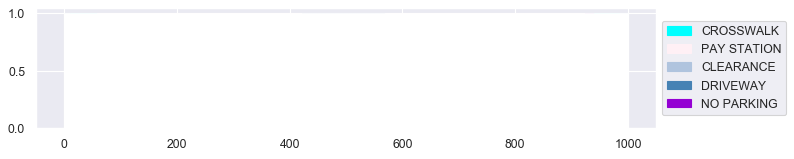

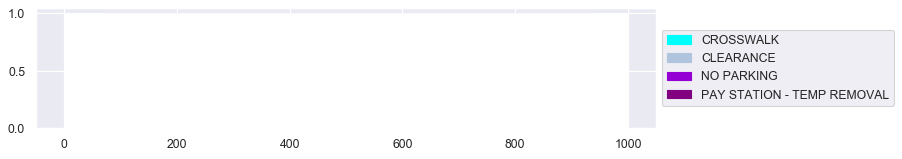

In [29]:
#need this to be subplot function, create legend for each subplot
#https://stackoverflow.com/questions/27016904/matplotlib-legends-in-subplot

#load a model, plot the centroids


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
    


for cluster_i in range(len(km.cluster_centroids_)):

    height = [1 for i in range(all_data.shape[1])]
    x_pos = np.arange(len(height))

    plt.figure(figsize=(10,2), dpi=80)
    plt.bar(x_pos, height, width=1, align="center", color=[ space_integer_color_map[k] for k in km.cluster_centroids_[cluster_i] ])

    labels = list(set(km.cluster_centroids_[cluster_i]))
    handles = [plt.Rectangle((0,0),1,1, color=space_integer_color_map[label]) for label in labels]
    plt.legend(handles, [space_types[i] for i in labels ], loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

#### Clustering blockfaces of similar true length

In [ ]:
ekeys_trunc = length_bins[11] #these blockfaces are all in the [275,300) foot length interval, the largest set of similarly lengthed blockfaces in the city

for ekey in ekeys_trunc:

#### Clustering blockfaces in the core downtown

Here we load a specially curated GIS dataset of every blockface in Seattle that lists blockface latitude and longitude locations by neighborhood. We use this data, available [here](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::blockface/about) to seperate out only blockfaces in the Belltown, Financial District, International District (named Chinatown/ID), Commerical Core, Pioneer Square, Pike-Pine, South Lake Union, and Denny Triangle neighborhoods

In [96]:
#also check Uptown, variable in json is "PAIDAREA", could also just get all blockfaces within a radius of center of downtown
import json

with open("Blockface.geojson") as d:
    loc_data = json.load(d)

blockface_dicts = loc_data['features'] #list of all data features in blockface json file, not all elements are relevant blockface entries

ekey_to_loc = {}
ekey_to_neighborhood = {}
area_to_ekeys = {}

for i in range(len(blockface_dicts)):
    ekey = blockface_dicts[i]['properties']['ELMNTKEY']
    coords = blockface_dicts[i]['geometry']['coordinates']
    area = blockface_dicts[i]['properties']['PAIDAREA']
    
    if ekey in ekeys: #ensure its a blockface in the zoning data set
        ekey_to_loc[ekey] = coords
        ekey_to_neighborhood[ekey] = area
        
        #create a convenient mapping of a neighborhood to all of its constituent elementkeys
        if area not in area_to_ekeys:
            area_to_ekeys[area] = [ekey]
        else:
            area_to_ekeys[area].append(ekey)

In [98]:
#Print all "PAIDAREA" neighborhoods
print(area_to_ekeys.keys())

#neighborhoods in core downtown
core_downtown = ['Pioneer Square', 'Commercial Core', 'Belltown', 'Pike-Pine', 'South Lake Union', 'Denny Triangle', 'Uptown', 'Westlake Ave N', 'Chinatown/ID', '12th Avenue', 'Uptown Triangle', 'Columbia City']

dict_keys(['Capitol Hill', 'Green Lake', 'Pioneer Square', 'Commercial Core', 'Ballard', 'Belltown', 'First Hill', 'Pike-Pine', 'South Lake Union', 'Denny Triangle', None, 'Uptown', 'Cherry Hill', 'Westlake Ave N', 'Chinatown/ID', '12th Avenue', 'University District', 'Uptown Triangle', 'Columbia City', 'Ballard Locks', 'Lake Union Park', 'Roosevelt', 'Fremont'])

In [100]:
#to visualize need to create a conda environment

#def map_ekeys(ekeys, allocation_map, color_map):
#    coord_list =[]
#
#    for key in ekeys:
#
#        new_dict = allocation_map[key]
#        bin_coords = new_dict["bin_coords"]
#        coord_df = pd.DataFrame(bin_coords)
#        coord_df.columns = ["lat","long"]#
#
#        allocations = new_dict["allocation"]
#        allocation_df = pd.DataFrame(allocations)
#        allocation_df.columns = ["allocation"]#
#
#        joined_df = coord_df.join(allocation_df)
#        coord_list.append(joined_df)##
#
#    df = pd.concat(coord_list, axis=0)
#    df['size'] = 0.25
#    df['color'] = df['allocation'].map(color_map)
#
#    return df


#def plot_map(df, color_map):
#    fig = px.scatter_mapbox(df[['lat','long','allocation','color', 'size']], lat='lat', lon='long', 
#    		color='allocation',  color_discrete_map=color_map, opacity=1, size='size', zoom=16)
#    fig.update_layout(mapbox_style="carto-positron")#"open-street-map")
#    fig.show()
 
lats = 
    
fig = px.line_geo(lat=lats, lon=lons, hover_name=names)
fig.update_layout(mapbox_style="carto-positron")
fig.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 20)

In [101]:
import plotly.express as px
import geopandas as gpd
import shapely.geometry
import numpy as np
import wget

# download a zipped shapefile
wget.download("https://plotly.github.io/datasets/ne_50m_rivers_lake_centerlines.zip")

# open a zipped shapefile with the zip:// pseudo-protocol
geo_df = gpd.read_file("zip://ne_50m_rivers_lake_centerlines.zip")

lats = []
lons = []
names = []

for feature, name in zip(geo_df.geometry, geo_df.name):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)

fig = px.line_geo(lat=lats, lon=lons, hover_name=names)
fig.show()

ModuleNotFoundError: No module named 'plotly'